In [1]:
import pandas as pd
from CatalogDataReader import CatalogDataReader
from DataConverter import DataConverter
from TelemetryDataReader import TelemetryDataReader

MAIN_SPORT_DOCUMENT_FILE_NAME = 'sport_ttc_20220814.ods'

telemetry_reader = TelemetryDataReader()
catalog_data = CatalogDataReader()
data_converter = DataConverter()

main_tm_df = catalog_data.get_all_tms_on_the_document(MAIN_SPORT_DOCUMENT_FILE_NAME)
main_dd_df = catalog_data.get_all_dds_from_document(MAIN_SPORT_DOCUMENT_FILE_NAME)

telemetry_file_name = 'hk_vur_inst_only.out'

df = telemetry_reader.get_space_packets_df_from_file(telemetry_file_name, main_dd_df)
df

,version_number,pkt_type,sec_hdr_flag,apid,seq_flags,seq_count,pkt_data_length,secondary_header,data,checksum,data_transformed
0,0,0,1,0x8,0x3,00001111101111,0x2d,1980-01-06 08:24:22.489,0000100101111001000010010001011100000110011101...,0001010010001101,[{'field': 'Periodic instantaneous RX telemetr...
1,0,0,1,0x8,0x3,00001111110000,0x2d,2023-09-27 11:27:25.489,0000100011110100000010010110100000000101111001...,0000110011100100,[{'field': 'Periodic instantaneous RX telemetr...
2,0,0,1,0x8,0x3,00001111110001,0x2d,2023-09-27 11:27:55.489,0000100100100010000010001100010000000110011100...,0101011010111001,[{'field': 'Periodic instantaneous RX telemetr...
3,0,0,1,0x8,0x3,00001111110010,0x2d,2023-09-27 11:28:25.489,0000011111100100000010000001111100000110010110...,1110100110110110,[{'field': 'Periodic instantaneous RX telemetr...
4,0,0,1,0x8,0x3,00001111110011,0x2d,2023-09-27 11:28:55.486,0000011100000000000001111110100000000101110100...,1110011101110111,[{'field': 'Periodic instantaneous RX telemetr...
5,0,0,1,0x8,0x3,00001111110100,0x2d,2023-09-27 11:29:25.486,0000100110010000000010010000100000000110010100...,1111010010011000,[{'field': 'Periodic instantaneous RX telemetr...
6,0,0,1,0x8,0x3,00001111110101,0x2d,2023-09-27 11:29:55.486,0000100011000111000010001100000100000110010100...,0110011110010110,[{'field': 'Periodic instantaneous RX telemetr...
7,0,0,1,0x8,0x3,00001111110110,0x2d,2023-09-27 11:30:25.486,0000100010011010000010010110000000000101110011...,1011011010110001,[{'field': 'Periodic instantaneous RX telemetr...
8,0,0,1,0x8,0x3,00001111110111,0x2d,2023-09-27 11:30:55.487,0000100011011111000010011000111100000110011001...,1010010101110011,[{'field': 'Periodic instantaneous RX telemetr...
9,0,0,1,0x8,0x3,00001111111001,0x2d,2023-09-27 11:31:55.487,0000100000111010000010001111111000000110100000...,0101001010000100,[{'field': 'Periodic instantaneous RX telemetr...


In [2]:


y = []
field_id = 2

teste_df = df.query("""apid == '0x8'""").copy()

for i in range(0, len(teste_df)):
    field_data = (teste_df.iloc[i, :]['data_transformed'])[field_id]
    field_name = field_data['field']
    field_unit = field_data['unit']
    observation = field_data['observation']
    y.append(field_data['value'])

new_df = teste_df['secondary_header'].reset_index().copy()
print(observation)
new_df[f"{field_name} ({field_unit})"] = y
new_df = new_df.rename(columns={'secondary_header':'time'})
new_df = new_df.drop(columns='index').set_index('time')

new_df#.loc['2023-01-01':].plot()

None


,Instantaneous RSSI (dBm)
time,
1980-01-06 08:24:22.489,-82.19
2023-09-27 11:27:25.489,-79.76
2023-09-27 11:27:55.489,-84.68
2023-09-27 11:28:25.489,-89.63
2023-09-27 11:28:55.486,-91.28
2023-09-27 11:29:25.486,-82.64
2023-09-27 11:29:55.486,-84.77
2023-09-27 11:30:25.486,-80.00
2023-09-27 11:30:55.487,-78.59


In [3]:

def check_all_values_none(data, exclude_keys=None):
    if exclude_keys is None:
        exclude_keys = []

    if isinstance(data, dict):
        is_empty = all(value is None for key, value in data.items() if key not in exclude_keys)
    elif isinstance(data, list):
        is_empty = all(value is None for value in data)
    else:
        raise NotImplementedError
    
    return is_empty

available_apids = df['apid'].unique()

apid_df_dict = {}
for apid in df['apid'].unique():
    new_df = telemetry_reader.get_specific_apid_df_from_telemetry_df(apid, df, main_dd_df)

    apid_df_dict[apid] = new_df

apid_df_dict['0x8']

,Periodic instantaneous RX telemetry: Instantaneous Doppler offset (Hz),Periodic instantaneous RX telemetry: Instantaneous RSSI (dBm),Periodic instantaneous RX telemetry: Power bus voltage (V),Periodic instantaneous RX telemetry: Total supply current (mA),Periodic instantaneous RX telemetry: Transmitter current (mA),Periodic instantaneous RX telemetry: Receiver current (mA),Periodic instantaneous RX telemetry: Power amplifier current (mA),Periodic instantaneous RX telemetry: Power amplifier temperature (°C),Periodic instantaneous RX telemetry: Local oscillator temperature (°C),Periodic last transmission TX telemetry: Instantaneous RF reflected power (dBm),Periodic last transmission TX telemetry: Instantaneous RF forward power (dBm),Periodic last transmission TX telemetry: Power bus voltage (V),Periodic last transmission TX telemetry: Total supply current (mA),Periodic last transmission TX telemetry: Transmitter current (mA),Periodic last transmission TX telemetry: Receiver current (mA),Periodic last transmission TX telemetry: Power amplifier current (mA),Periodic last transmission TX telemetry: Power amplifier temperature (°C),Periodic last transmission TX telemetry: Local oscillator temperature (°C)
time,,,,,,,,,,,,,,,,,,
1980-01-06 08:24:22.489,10078.600,-82.19,8.07152,49.599013,12.649413,98.032948,0.166440,10.62742,8.63348,29.342927,717.864548,7.88608,402.950368,160.281373,98.365827,418.096376,10.55073,8.48010
2023-09-27 11:27:25.489,8302.784,-79.76,7.37368,53.593564,12.815852,97.700069,0.166440,10.85749,8.78686,31.285932,709.665134,8.12032,399.621576,159.948494,98.532267,403.949006,10.70411,8.63348
2023-09-27 11:27:55.489,8916.976,-84.68,8.05688,49.266133,12.316533,98.365827,0.166440,11.01087,8.94024,31.114502,722.394300,7.93976,390.800275,160.114934,98.032948,408.942195,10.93418,8.71017
2023-09-27 11:28:25.489,4671.040,-89.63,7.93000,204.221438,157.451899,99.364465,190.074069,11.16425,9.01693,30.348898,693.811737,7.86168,392.131792,160.447813,98.199388,410.107273,11.16425,8.86355
2023-09-27 11:28:55.486,1626.784,-91.28,7.26632,440.066408,158.949856,99.031586,427.084116,12.39129,9.17031,29.259862,719.098522,7.27120,427.250556,158.783417,98.698707,412.104549,12.23791,9.01693
2023-09-27 11:29:25.486,10385.696,-82.64,7.89584,401.452412,158.783417,98.199388,443.228761,14.84537,9.86052,30.095816,751.133162,7.90560,392.797550,158.949856,98.698707,421.425168,14.69199,9.70714
2023-09-27 11:29:55.486,7701.944,-84.77,7.90072,406.778480,158.949856,98.532267,407.277799,16.07241,10.55073,29.342927,712.120013,7.96416,395.127705,159.282735,98.865146,409.441514,15.99572,10.47404
2023-09-27 11:30:25.486,7101.104,-80.00,7.25656,430.412909,158.949856,98.199388,432.909504,17.06938,11.24094,29.509412,714.168983,7.25168,431.245107,159.116296,98.365827,410.939471,16.91600,11.08756
2023-09-27 11:30:55.487,8022.392,-78.59,7.98368,384.974887,159.116296,98.032948,416.431979,17.91297,11.85446,29.342927,712.939248,7.97392,391.632473,159.449175,98.199388,421.258729,17.68290,11.70108


In [4]:
pd.DataFrame(main_dd_df.query(f"""apid == '0x8'""")['data_packets'].item()).fillna('').replace('N/A', '')

,field,lenght(bits),format,nominal_minimum,nominal_maximum,conversion,unit,observation
0,Periodic instantaneous RX telemetry:,,,,,,,
1,Instantaneous Doppler offset,16.0,12-bit ADC,,,adc*13.352-22300,Hz,
2,Instantaneous RSSI,16.0,12-bit ADC,,,adc*0.03–152,dBm,
3,Power bus voltage,16.0,12-bit ADC,,,adc*0.00488,V,
4,Total supply current,16.0,12-bit ADC,,,adc*0.16643964,mA,
5,Transmitter current,16.0,12-bit ADC,,,adc*0.16643964,mA,
6,Receiver current,16.0,12-bit ADC,,,adc*0.16643964,mA,
7,Power amplifier current,16.0,12-bit ADC,,,adc*0.16643964,mA,
8,Power amplifier temperature,16.0,12-bit ADC,-30.0,85.0,adc*-0.07669+195.6037,°C,
9,Local oscillator temperature,16.0,12-bit ADC,-30.0,50.0,adc*-0.07669+195.6037,°C,


In [5]:
possible_fields = []
for i, dict in enumerate(main_dd_df.query(f"""apid == '0x8'""")['data_packets'].item()):
    field = dict['field']
    unit = dict['unit']
    if field == 'Total':
        break
    possible_fields.append(f"{field} ({unit}) {i}")
    print(f"{field} ({unit}) {i}")

possible_fields

Periodic instantaneous RX telemetry: (None) 0
Instantaneous Doppler offset (Hz) 1
Instantaneous RSSI (dBm) 2
Power bus voltage (V) 3
Total supply current (mA) 4
Transmitter current (mA) 5
Receiver current (mA) 6
Power amplifier current (mA) 7
Power amplifier temperature (°C) 8
Local oscillator temperature (°C) 9
Periodic last transmission TX telemetry: (None) 10
Instantaneous RF reflected power (dBm) 11
Instantaneous RF forward power (dBm) 12
Power bus voltage (V) 13
Total supply current (mA) 14
Transmitter current (mA) 15
Receiver current (mA) 16
Power amplifier current (mA) 17
Power amplifier temperature (°C) 18
Local oscillator temperature (°C) 19


['Periodic instantaneous RX telemetry: (None) 0',
 'Instantaneous Doppler offset (Hz) 1',
 'Instantaneous RSSI (dBm) 2',
 'Power bus voltage (V) 3',
 'Total supply current (mA) 4',
 'Transmitter current (mA) 5',
 'Receiver current (mA) 6',
 'Power amplifier current (mA) 7',
 'Power amplifier temperature (°C) 8',
 'Local oscillator temperature (°C) 9',
 'Periodic last transmission TX telemetry: (None) 10',
 'Instantaneous RF reflected power (dBm) 11',
 'Instantaneous RF forward power (dBm) 12',
 'Power bus voltage (V) 13',
 'Total supply current (mA) 14',
 'Transmitter current (mA) 15',
 'Receiver current (mA) 16',
 'Power amplifier current (mA) 17',
 'Power amplifier temperature (°C) 18',
 'Local oscillator temperature (°C) 19']

In [6]:
apid_df_dict['0x8']

,Periodic instantaneous RX telemetry: Instantaneous Doppler offset (Hz),Periodic instantaneous RX telemetry: Instantaneous RSSI (dBm),Periodic instantaneous RX telemetry: Power bus voltage (V),Periodic instantaneous RX telemetry: Total supply current (mA),Periodic instantaneous RX telemetry: Transmitter current (mA),Periodic instantaneous RX telemetry: Receiver current (mA),Periodic instantaneous RX telemetry: Power amplifier current (mA),Periodic instantaneous RX telemetry: Power amplifier temperature (°C),Periodic instantaneous RX telemetry: Local oscillator temperature (°C),Periodic last transmission TX telemetry: Instantaneous RF reflected power (dBm),Periodic last transmission TX telemetry: Instantaneous RF forward power (dBm),Periodic last transmission TX telemetry: Power bus voltage (V),Periodic last transmission TX telemetry: Total supply current (mA),Periodic last transmission TX telemetry: Transmitter current (mA),Periodic last transmission TX telemetry: Receiver current (mA),Periodic last transmission TX telemetry: Power amplifier current (mA),Periodic last transmission TX telemetry: Power amplifier temperature (°C),Periodic last transmission TX telemetry: Local oscillator temperature (°C)
time,,,,,,,,,,,,,,,,,,
1980-01-06 08:24:22.489,10078.600,-82.19,8.07152,49.599013,12.649413,98.032948,0.166440,10.62742,8.63348,29.342927,717.864548,7.88608,402.950368,160.281373,98.365827,418.096376,10.55073,8.48010
2023-09-27 11:27:25.489,8302.784,-79.76,7.37368,53.593564,12.815852,97.700069,0.166440,10.85749,8.78686,31.285932,709.665134,8.12032,399.621576,159.948494,98.532267,403.949006,10.70411,8.63348
2023-09-27 11:27:55.489,8916.976,-84.68,8.05688,49.266133,12.316533,98.365827,0.166440,11.01087,8.94024,31.114502,722.394300,7.93976,390.800275,160.114934,98.032948,408.942195,10.93418,8.71017
2023-09-27 11:28:25.489,4671.040,-89.63,7.93000,204.221438,157.451899,99.364465,190.074069,11.16425,9.01693,30.348898,693.811737,7.86168,392.131792,160.447813,98.199388,410.107273,11.16425,8.86355
2023-09-27 11:28:55.486,1626.784,-91.28,7.26632,440.066408,158.949856,99.031586,427.084116,12.39129,9.17031,29.259862,719.098522,7.27120,427.250556,158.783417,98.698707,412.104549,12.23791,9.01693
2023-09-27 11:29:25.486,10385.696,-82.64,7.89584,401.452412,158.783417,98.199388,443.228761,14.84537,9.86052,30.095816,751.133162,7.90560,392.797550,158.949856,98.698707,421.425168,14.69199,9.70714
2023-09-27 11:29:55.486,7701.944,-84.77,7.90072,406.778480,158.949856,98.532267,407.277799,16.07241,10.55073,29.342927,712.120013,7.96416,395.127705,159.282735,98.865146,409.441514,15.99572,10.47404
2023-09-27 11:30:25.486,7101.104,-80.00,7.25656,430.412909,158.949856,98.199388,432.909504,17.06938,11.24094,29.509412,714.168983,7.25168,431.245107,159.116296,98.365827,410.939471,16.91600,11.08756
2023-09-27 11:30:55.487,8022.392,-78.59,7.98368,384.974887,159.116296,98.032948,416.431979,17.91297,11.85446,29.342927,712.939248,7.97392,391.632473,159.449175,98.199388,421.258729,17.68290,11.70108


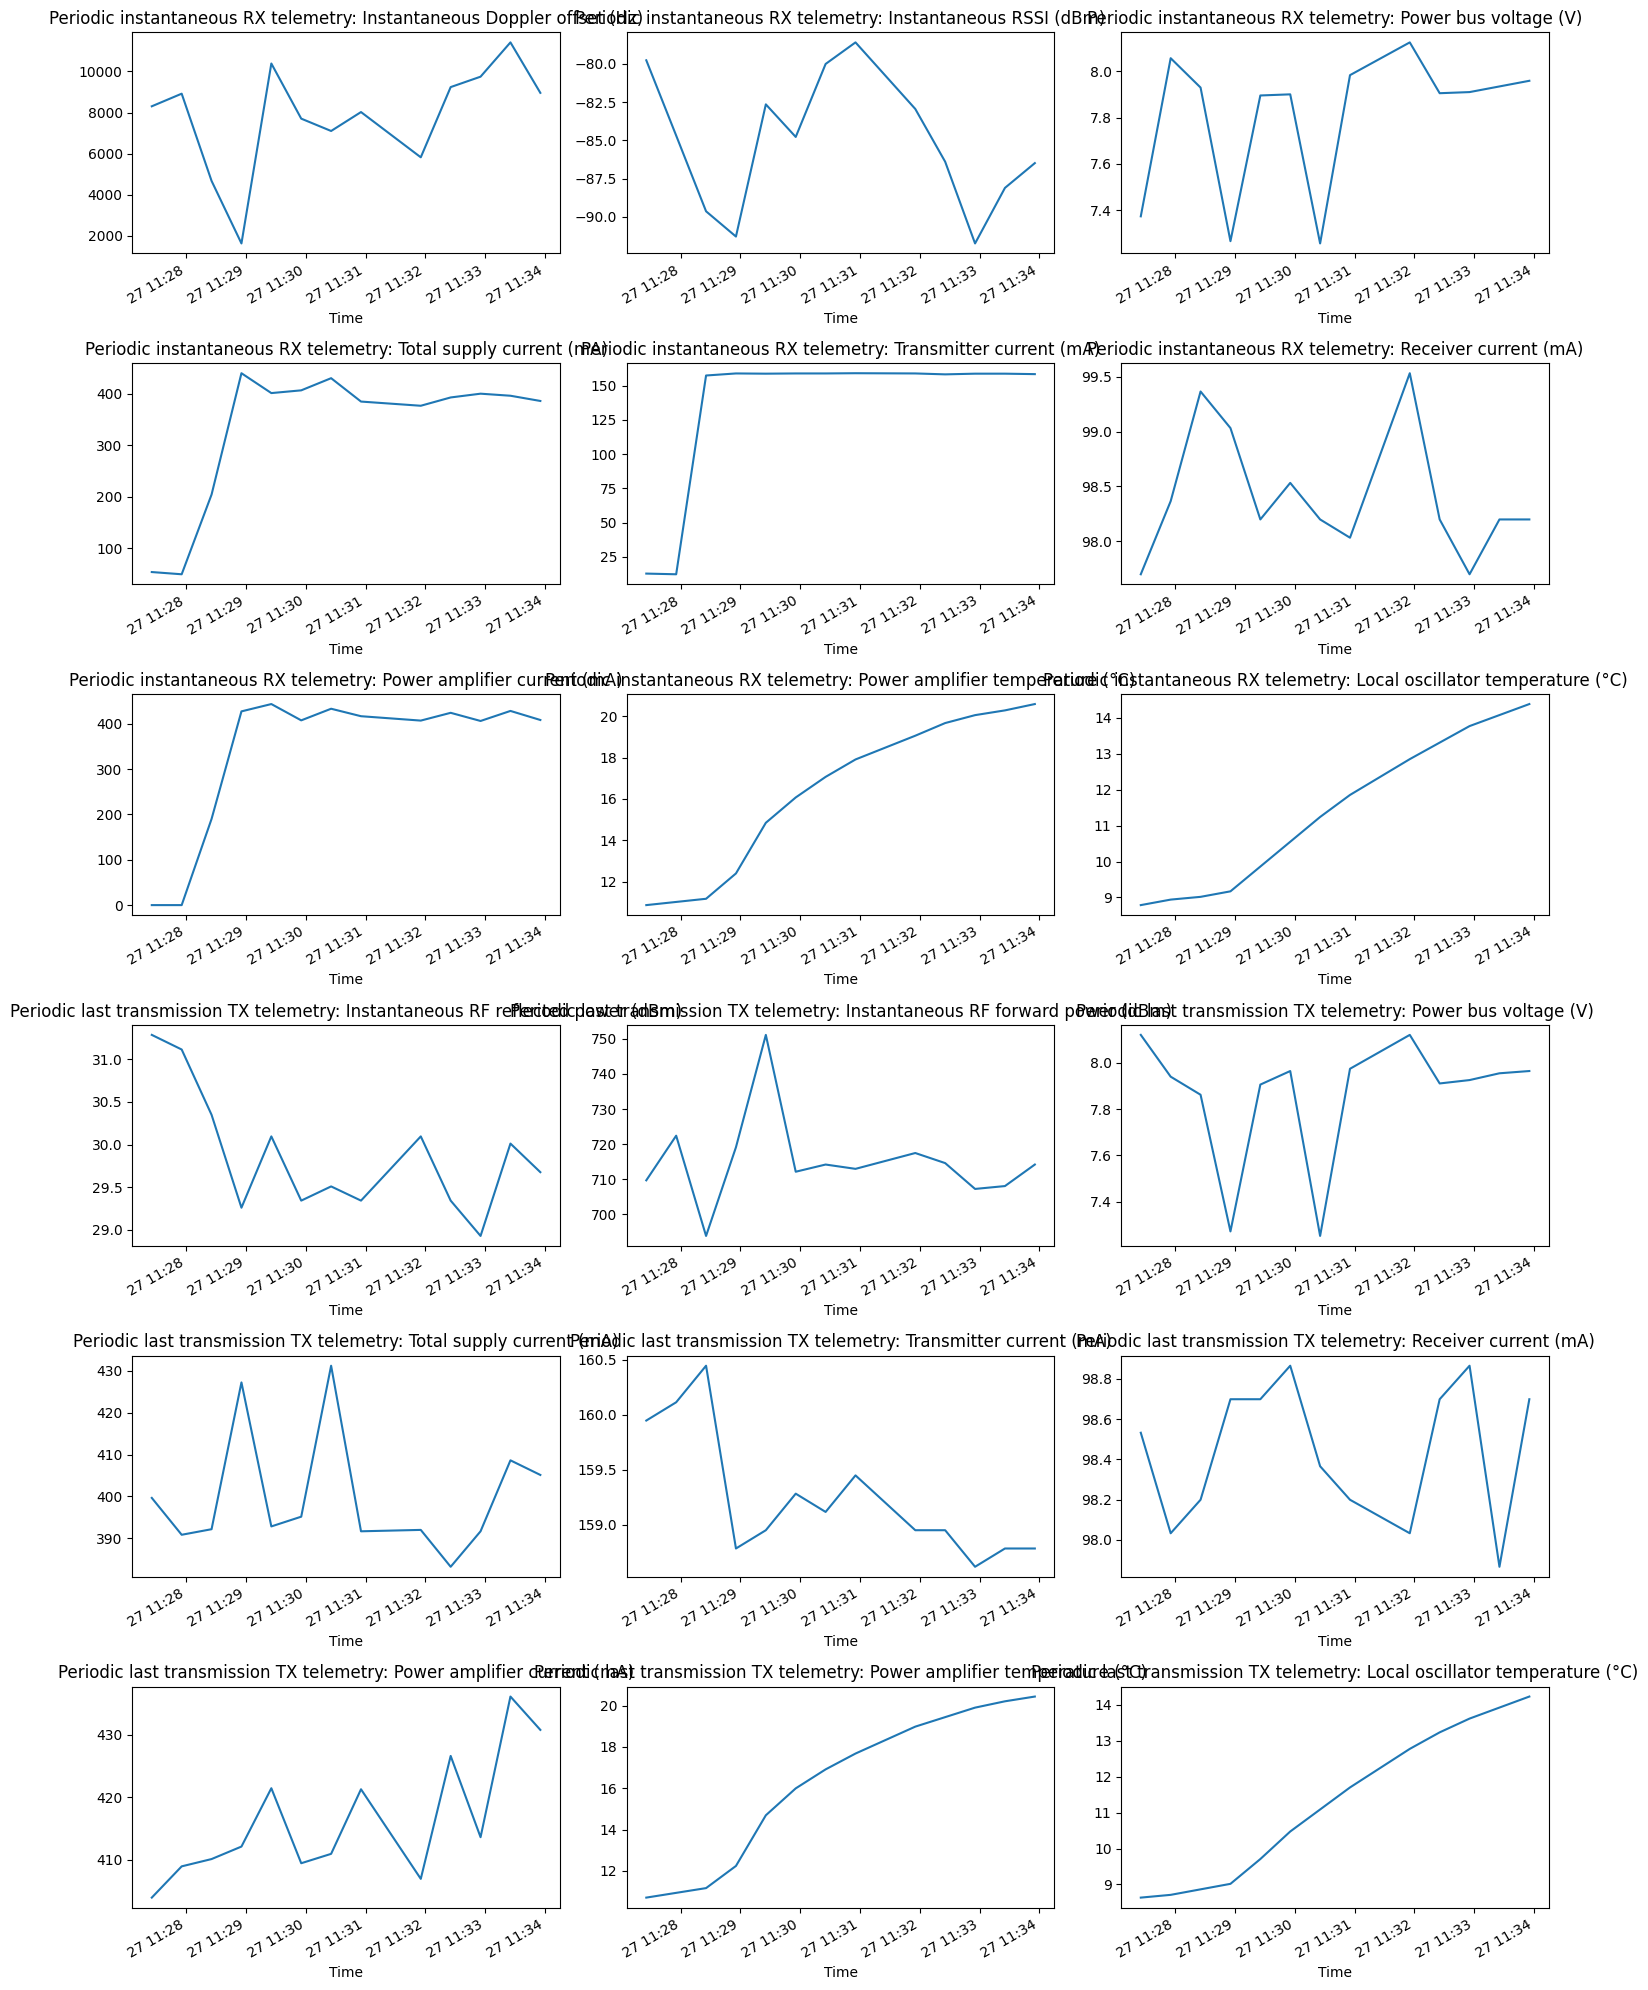

In [7]:
from matplotlib import pyplot as plt


plot_df = apid_df_dict['0x8'].loc['2020-01-01':].dropna(axis=1)

# Calculate number of rows needed for two columns
n_columns = 3
n_rows = -(-len(plot_df.columns) // n_columns)  # This is a ceiling division

# Create subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(15, 20))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for ax, column in zip(axs, plot_df.columns):
    plot_df[column].plot(ax=ax, title=column)
    ax.set_xlabel('Time')
    # ax.set_ylabel(column)

# Hide any empty subplots
for ax in axs[len(plot_df.columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()